<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/99d_insurance_federated_wrapup_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Insurance

Open

- [ ] ~~RSquared for FL, but it is only available in tf-nightly and the installation broke the env~~
- [ ] document input and outputs in FLutils

## Prerequisites
---

### Libraries
---

In [1]:
# Setup colab if needed

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("COLAB? {}".format(IN_COLAB))

if IN_COLAB:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

    !pip install -q tensorflow-federated==0.56.0
    # or possibly !pip install -r requirements.txt

    os.chdir("_dev")



COLAB? False


In [2]:
!python --version
# tested 3.9.* or 3.10.*.

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Python 3.9.16


In [3]:
# show library versions
# =========================
!pip list | grep tensorflow
# tensorflow                    2.12.0
# tensorflow-federated          0.56.0

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
tensorflow                    2.12.0
tensorflow-addons             0.20.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [4]:
# suppress tf debug logging
# =========================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [5]:
# imports
# =======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split, RepeatedStratifiedKFold

from keras.callbacks import CSVLogger

from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_model,train_fed
#import FLutils

# logging path
out_path = '../output/experiments' 

### Data preperation
---

In [6]:
# ingest data
# ===========

df_paths = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_paths)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [7]:
# select features, target (first column) and clients
# ==================================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']

features_fed = features[:5]

target = 'charges'

clients = df.region.unique()

df.loc[:, [target] + features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


### Budget
---

#### Evaluation

In [8]:
# create evaluation splits
# ========================

nreps, nfolds = 10, 5
evaluation = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)

#client_splits = [list(rsmp.split(data)) for data in clients]
#print("number of splits per client: %s" % [np.array(client, dtype = object).shape[0] for client in client_splits])

#### Training

In [9]:
n_epochs     = 100
n_epochs_fed =  50
n_rounds_fed =  50  

### Model
---

In [10]:
# define model architecture
def keras_blueprint(compile = False, nfeatures = len(features_fed)):
    if nfeatures == None: nfeatures = len(features)
    
    return create_keras_model(
        nfeatures = nfeatures, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
# S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras

# loss = mae -> overfitting?

keras_blueprint().summary()
keras_blueprint(compile=True).get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

## Federated Learning
---

In [11]:
experiment_name = '06_federated_fix'

experiment_path = out_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### FED Train 
---

In [1]:
list(evaluation.split(df, df.region))

NameError: name 'evaluation' is not defined

In [12]:
# compute train
# =============
results_fed = []

eval_ind = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))[]):

    # Logging
    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    eval_ind += 1
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))


    # distribute train (and eval) data over the client and prep tensors.
    train_data_fed = []
    eval_data_fed  = []   
    for client in clients:
        outer_train_data_client = df[(df.index.isin(train)) & (df.region == client)]
        train_data_client, eval_data_client = train_test_split(outer_train_data_client, test_size = 0.1, random_state = 42)
        
        train_data_fed.append(
            prep_fed_train(train_data_client[features_fed], train_data_client[target])) 
        eval_data_fed.append(
            prep_fed_test(eval_data_client[features_fed], eval_data_client[target]))
        
    # train
    #with tf.device('/device:gpu:0'): # possibly needed for colab
    result =  train_fed(
        model = model_fn(
            keras_creator = keras_blueprint,
            loss = tf.losses.MeanSquaredError()
        ),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        NUM_ROUNDS = n_rounds_fed,
        NUM_EPOCHS = n_epochs_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )
    # caching
    pd.DataFrame(result['history']).to_csv(experiment_path + "logs/" + id + '_log.csv', sep = ";")

    model = keras_blueprint()
    model_weights = result['process'].get_model_weights(result['state'])
    model_weights.assign_weights_to(model)
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    # load with e.g. 
    # model = keras_blueprint(compile = True)
    # model.load_weights(experiment_path + 'models/r0f0_weights.h5')
    # model.weights

    results_fed.append(result)

 76%|███████▌  | 38/50 [27:04<1:00:13, 301.12s/it]

: 

: 

In [ ]:
# show train result
# =======================
table = pd.DataFrame([res['history'][-1] for res in results_fed])
table.describe().to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,5.00,5.0,5.00,5.00,5.00,5.00,5.0,5.0,5.0,5.0
mean,2709.56,21264758.0,21237530.00,48120.00,378.20,4024.61,36053656.0,36686868.0,108.0,4.0
std,106.57,1170651.0,1065610.12,27.39,0.45,514.79,5753625.0,6086094.0,0.0,0.0
min,2542.32,19805508.0,19861834.00,48100.00,378.00,3208.26,29004000.0,29262606.0,108.0,4.0
25%,2684.79,20280612.0,20362058.00,48100.00,378.00,3975.63,32567062.0,33598416.0,108.0,4.0
50%,2733.07,21680022.0,21705348.00,48100.00,378.00,4035.70,36854920.0,36490624.0,108.0,4.0
75%,2761.43,22000776.0,21936744.00,48150.00,378.00,4337.16,37564400.0,38427168.0,108.0,4.0
max,2826.20,22556878.0,22321668.00,48150.00,379.00,4566.28,44277916.0,45655524.0,108.0,4.0


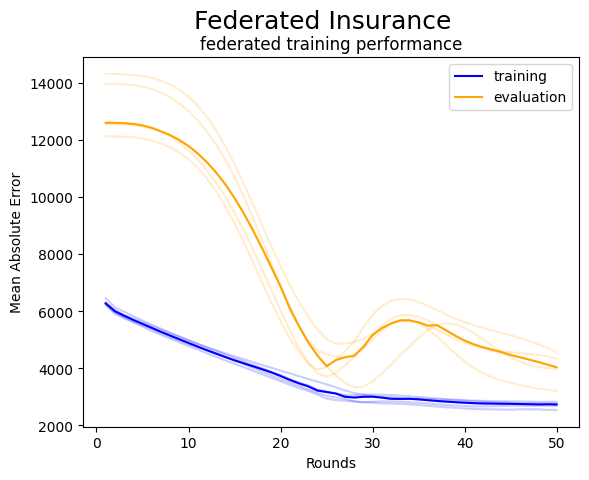

In [ ]:
# plot train result (MAE)
# =======================
y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()

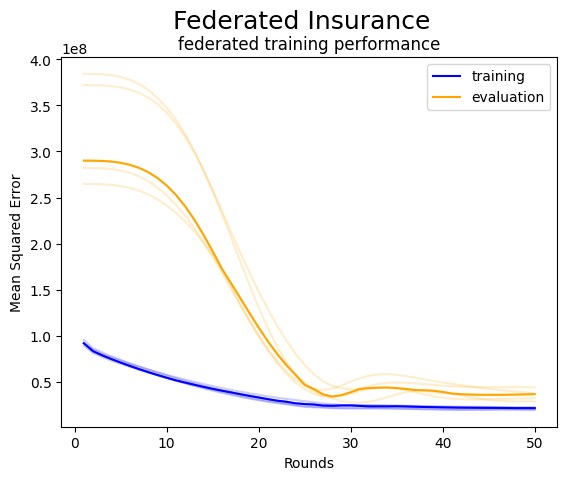

In [ ]:
# plot train result (MSE)
# =======================

y = np.array([[hist['mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Squared Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mse.png')
plt.show()

### FED Test
---

In [ ]:
# calculate test
# ==============
results_fed_test = []

model = keras_blueprint(compile = True)

i = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):
    data_test = df.loc[test]
    X_test, y_test = data_test[features_fed], data_test[target]
    
    # calculate test performance
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    i += 1
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)


100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


In [ ]:
# show test results
# =================
table2 = pd.DataFrame(results_fed_test)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)

table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")
table_all_fed = pd.concat([table, table2], axis = 1)
table_all_fed.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all_fed.to_csv(experiment_path + "results/performance.csv", sep = ";")

table_all_fed.describe()[1:].transpose().round(4)

,mean,std,min,25%,50%,75%,max
mean_absolute_error,2.709562e+03,1.065720e+02,2.542321e+03,2.684795e+03,2.733067e+03,2.761428e+03,2.826202e+03
mean_squared_error,2.126476e+07,1.170651e+06,1.980551e+07,2.028061e+07,2.168002e+07,2.200078e+07,2.255688e+07
loss,2.123753e+07,1.065610e+06,1.986183e+07,2.036206e+07,2.170535e+07,2.193674e+07,2.232167e+07
num_examples,4.812000e+04,2.738610e+01,4.810000e+04,4.810000e+04,4.810000e+04,4.815000e+04,4.815000e+04
num_batches,3.782000e+02,4.472000e-01,3.780000e+02,3.780000e+02,3.780000e+02,3.780000e+02,3.790000e+02
val_mean_absolute_error,4.024606e+03,5.147908e+02,3.208260e+03,3.975633e+03,4.035699e+03,4.337161e+03,4.566275e+03
val_mean_squared_error,3.605366e+07,5.753625e+06,2.900400e+07,3.256706e+07,3.685492e+07,3.756440e+07,4.427792e+07
val_loss,3.668687e+07,6.086094e+06,2.926261e+07,3.359842e+07,3.649062e+07,3.842717e+07,4.565552e+07
val_num_examples,1.080000e+02,0.000000e+00,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02
val_num_batches,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00


## Centralized DNN
---

### Setup
---

Using 9 Features.

In [ ]:
experiment_name = '07_central_fix'

experiment_path = out_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### CTR Train
---

In [ ]:
# calculate training
# ==================
results_ctr = []

eval_ind = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):

    # Logging
    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    eval_ind += 1
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))
    
    
    data_train = df.loc[train]
    X_train, y_train = data_train[features], data_train[target]

    model = keras_blueprint(nfeatures = len(features), compile = True)
    
    result = train_model(
        model, X_train, y_train,
        epochs = n_epochs, 
        #output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")],
        seed = 42,
        verbose = False
    )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')

    results_ctr.append(result)


100%|██████████| 5/5 [03:35<00:00, 43.17s/it]


In [ ]:
# show train results
# ==================
table = pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    r2_score    = lambda x: x.r2_score * 100,
    val_r2_score = lambda x: x.val_r2_score * 100
)

table.describe()[1:].to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.round(2)

,loss,mae,mean_squared_error,r2_score,val_loss,val_mae,val_mean_squared_error,val_r2_score
0,21626550.0,2757.34,21626550.0,84.22,29159864.0,2880.28,29159864.0,81.31
1,19210398.0,2495.15,19210398.0,86.60,20524956.0,2673.47,20524956.0,84.92
2,20410248.0,2650.53,20410248.0,85.89,25338486.0,2865.97,25338486.0,84.46
3,22505218.0,2851.87,22505218.0,83.61,28212950.0,3007.68,28212950.0,82.67
4,21713006.0,2729.77,21713006.0,84.38,23644974.0,2766.91,23644974.0,85.00


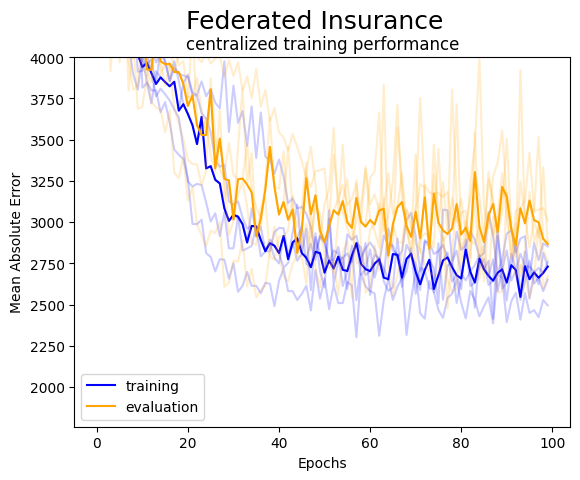

In [ ]:
# plot train result (MAE)
# =======================
y1 = np.array([hist.history["mae"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_mae"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([None, 4000])

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()


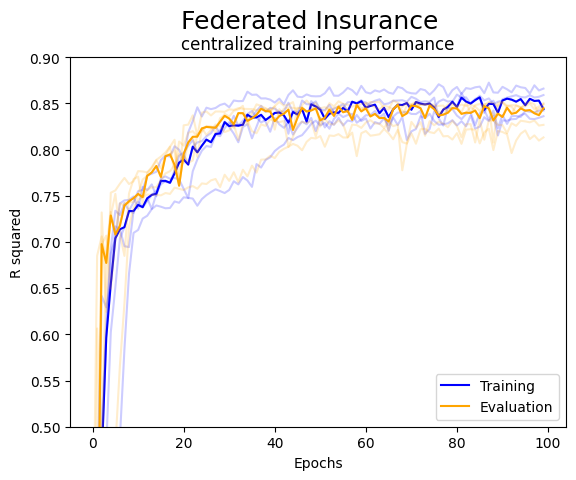

In [ ]:
# plot train result (RSQ)
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'Training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'Evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epochs")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_rsq.png')
plt.show()



### CTR Test
---

In [ ]:
# compute test
# ============
results_test_ctr = []

i = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):
    data_test = df.loc[test]
    
    X_test, y_test = data_test[features], data_test[target]
    
    
    model = results_ctr[i].model
    i += 1
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


In [ ]:
# show test results
# =================
table2 = pd.DataFrame(results_test_ctr)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)


table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")

table_all_ctr = pd.concat([table, table2], axis = 1)
table_all_ctr.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all_ctr.to_csv(experiment_path + "results/performance.csv", sep = ";")
table_all_ctr.describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,21093084.00,1291683.33,19210398.00,20410248.00,21626550.00,21713006.00,22505218.00
mae,2696.93,133.79,2495.15,2650.53,2729.77,2757.34,2851.87
mean_squared_error,21093084.00,1291683.33,19210398.00,20410248.00,21626550.00,21713006.00,22505218.00
r2_score,84.94,1.25,83.61,84.22,84.38,85.89,86.60
val_loss,25376246.00,3496297.97,20524956.00,23644974.00,25338486.00,28212950.00,29159864.00
val_mae,2838.86,125.98,2673.47,2766.91,2865.97,2880.28,3007.68
val_mean_squared_error,25376246.00,3496297.97,20524956.00,23644974.00,25338486.00,28212950.00,29159864.00
val_r2_score,83.67,1.62,81.31,82.67,84.46,84.92,85.00
test_loss,24018629.60,4398154.52,19051912.00,19515894.00,26182234.00,26942430.00,28400678.00
test_mae,2700.98,197.87,2415.64,2604.53,2764.43,2785.30,2934.99


## Comparison
---

In [ ]:
tab = pd.concat(
    [
    table_all_fed.loc[:,table_all_fed.columns.str.contains("mean|loss|mae|score")].describe(percentiles = []).assign(type = "federated")[1:3].rename(
        columns = {'mean_absolute_error': 'mae',
                   
                   'val_mean_absolute_error': 'val_mae',
                   
                   'test_mean_absolute_error': 'test_mae'
                   }
    ).transpose(),
    table_all_ctr.describe(percentiles = []).assign(type = "centralized")[1:3].transpose()
    ],
    axis = 1)


tab.loc[['type','loss', 'mae', 'mean_squared_error', 'r2_score', 
         'val_loss', 'val_mae', 'val_mean_squared_error', 'val_r2_score','test_loss',
         'test_mae', 'test_mean_squared_error', 'test_r2_score'
       ]]

,mean,std,mean,std
type,federated,federated,centralized,centralized
loss,21237530.0,1065610.125,21093084.0,1291683.327163
mae,2709.562012,106.572029,2696.931445,133.790963
mean_squared_error,21264758.0,1170651.0,21093084.0,1291683.327163
r2_score,NaN,NaN,84.939982,1.250813
val_loss,36686868.0,6086094.0,25376246.0,3496297.969754
val_mae,4024.605957,514.790771,2838.861475,125.977295
val_mean_squared_error,36053656.0,5753625.0,25376246.0,3496297.969754
val_r2_score,NaN,NaN,83.67233,1.62284
test_loss,28387144.0,1840029.748531,24018629.6,4398154.515258
